In [19]:
%load_ext autoreload
import pandas as pd
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from scipy.ndimage import gaussian_filter
from functools import partial
import operator
from IPython.display import clear_output
from tqdm import tqdm
import networkx as nx
import timeit
import random
import copy
import community

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
%autoreload 2
from utils import summary, visualise, string_to_color, visualise_at_interval, convertImage, initialize_data_loader

# Canvas reproduction

In [4]:
visualise_at_interval(
    lambda rez, row : row.pixel_color, 
    lambda l : list(tqdm((convertImage(x,string_to_color) for x in l), total=len(l))), 
    pd.Timedelta(minutes = 15), 
    [["#FFFFFF" for i in range(2000)] for i in range(1000)],
    "image",
) 

ZeroDivisionError: division by zero

# Activity

In [19]:
def get_transform(images, blur = 0):
    blurImages =[gaussian_filter(np.array(img), blur) for img in images]
    maximum = np.max(blurImages)
    custom_cmap = ScalarMappable(cmap='RdBu_r', norm=LogNorm(vmin=1, vmax=maximum + 1))
    return [custom_cmap.to_rgba(img, bytes= True) for img in blurImages]

In [24]:

visualise_at_interval(
    lambda rez, row: rez + 1, 
    get_transform,
    pd.Timedelta(minutes = 15), 
    np.ones((1000,2000)),
    "activite",
    duration = pd.Timedelta(minutes = 30),
) 

loaded file : 2023_place_canvas_history-000000000019.csv.gzip

start making visualizations
results saved on activite.gif


In [26]:

visualise_at_interval(
    lambda rez, row : rez + 1, 
    get_transform, 
    -1, 
    np.ones((1000,2000)),
    "activite_total",
) 

loaded file : 2023_place_canvas_history-000000000019.csv.gzip

start making visualizations
results saved on activite_total.gif


In [ ]:
blurs =[1,2,5,10,50,100]
visualise_at_interval(
    lambda rez, row  : rez + 1, 
    { str(blur) : partial(get_transform, blur = blur) for blur in blurs}, 
    pd.Timedelta(minutes = 15), 
    np.ones((1000,1000)),
    lambda blur : f"activite_blur_{blur}",
    duration = pd.Timedelta(minutes = 30),
) 


visualise_at_interval(
    lambda rez, row : rez + int(not row.is_mod), 
    { str(blur) : partial(get_transform, blur = blur) for blur in blurs}, 
    pd.Timedelta(minutes = 15), 
    np.ones((1000,1000)),
    lambda blur : f"activite_blur_no_moderator_{blur}",
    duration = pd.Timedelta(minutes = 30),
) 


# Variété d'utilisateur

In [35]:
def compose(f, g):
    return lambda *args, **kwargs : f(g(*args, **kwargs))

def add_user(user, users):
    users.add(user)
    return users

def from_users_sets_by_points_to_len_by_points(images):
    return [[[len(user_set)+1 for user_set in row] for row in image] for image in images]

In [37]:
blurs =[1,5,10]
visualise_at_interval(
    lambda users, _, user, is_mod  : users if is_mod else add_user(user, users), 
    { str(blur) : compose(partial(get_transform, blur = blur),
                          from_users_sets_by_points_to_len_by_points) for blur in blurs}, 
    pd.Timedelta(minutes = 5), 
    [[set() for i in range(1000)] for j in range(1000)],
    lambda blur : f"users_variety_blur{blur}",
    duration = pd.Timedelta(minutes = 15),
)

just made summary from 2023-07-20 13:55:26.088000+00:00 to 2023-07-20 14:10:26.088000+00:00

start loading file: 2023_place_canvas_history-000000000000.csv
start formating data
loaded file : 2023_place_canvas_history-000000000000.csv
results saved on users_variety_blur1.gif
results saved on users_variety_blur5.gif
results saved on users_variety_blur10.gif


# Détection de communauté

In [8]:
ennemies = {}
moderators = set()

def get_ennemy_and_return_new_user(last_user, row, is_mod):

    if is_mod :
        moderators.add(row.user)
    if last_user :
        if not row.user in ennemies:
            ennemies[row.user] = {}
        ennemies[row.user][last_user] = ennemies[row.user].get(last_user, 0) + 1
    return row.user


visualise_at_interval(
    get_ennemy_and_return_new_user, 
    {}, 
    -1, 
    [["" for i in range(2000)] for j in range(1000)],
    "",
    EndingTimeStamp= pd.Timedelta(days= 1)
) 

loaded file : 2023_place_canvas_history-000000000001.csv.gzip

just made summary from 0 days 04:23:00 to 0 days 04:24:00
epochs : i


100%|██████████| 18690/18690 [00:00<00:00, 644190.50it/s]


KeyboardInterrupt: 

In [4]:
total_link = sum(len(neighbors) for neighbors in ennemies.values())
total_link

47163075

In [3]:
def make_symmetric(adj_dict):
    rez = copy.deepcopy(adj_dict)
    for node in adj_dict:
        for enemy in adj_dict[node]:
            rez[enemy][node] = adj_dict[enemy].get(node,0) + adj_dict[node].get(enemy,0)
    return rez

def normalize_weights(adj_dict):
    degree = { node : sum(neighbor.values()) for node, neighbor in adj_dict.items()}

    for node1 in adj_dict:
        for node2 in adj_dict[node1]:
            adj_dict[node1][node2] /= degree[node1]

def get_weight_from_stats(middle_weight,weight1, weight2):
    return middle_weight * (weight1 + weight2) / 4


def ennemies_of_enemies_are_friends(enemies):
    enemies = make_symmetric(enemies)
    degree = { node : sum(neighbor.values()) for node, neighbor in enemies.items()}
    enemies_of_enemies = {node : {enemy : -2*value / (degree[node] + degree[enemy]) for enemy, value in enemies[node].items()} for node in enemies}
    for node in enemies:
        for enemy, weight1 in enemies[node].items():
            for enemy_of_enemy, weight2 in enemies[enemy].items():
                if enemy_of_enemy != node :
                    enemies_of_enemies[node][enemy_of_enemy] = enemies_of_enemies[node].get(enemy_of_enemy,0) + get_weight_from_stats((weight1 + weight2)/degree[enemy], weight1/degree[node],weight2/degree[enemy_of_enemy])
    return enemies_of_enemies

def keep_only_above_threshold(graph, threshold):
    if threshold < 0 :
        raise ValueError("threshold needs to be a positive value")
    return {node : {neighbor : val for neighbor,val in neighbors.items() if val > threshold} for node, neighbors in tqdm(graph.items())}

def to_networkx(adj_dict):
    total_link = sum(len(neighbors) for neighbors in adj_dict.values())
    G= nx.Graph()
    G.add_edges_from(tqdm(((node1,node2,{'weight' : weight}) for node1, neighbors in adj_dict.items() for node2, weight in neighbors.items()), total= total_link, desc = "to_networkx"))
    return G

In [60]:
ennemies_of_enemies_are_friends(
    {
        1 : {2:1},
        2 : {1:1},
    }
)

{1: {2: 2}, 2: {1: 2}}


{1: {2: -1.0}, 2: {1: -1.0}}

In [4]:
n = 10000
friends = ennemies_of_enemies_are_friends({i : {j : 1 for j in range(n) if random.random() < 10/n} for i in range(n)})
above_threshold = keep_only_above_threshold(friends, 0)
G= to_networkx(above_threshold)
len(community.generate_dendrogram(G))


100%|██████████| 10/10 [00:00<00:00, 82565.04it/s]


2

In [9]:
print(range(5))

range(0, 5)


In [ ]:
# Create a NetworkX graph
G_ennemies = nx.Graph(tqdm(((node,neighbor) for node, neighbors in ennemies.items() for neighbor in neighbors), total= total_link))

In [6]:
import community

In [8]:
G_basic = nx.Graph()
G_basic.add_edges_from([(1,2),(2,3),(1,3),(1,4),(3,4),(1,5),(2,5),(4,5)])

In [9]:
community.generate_dendrogram(G_basic, inverted= True)

[{1: 0, 2: 0, 3: 0, 4: 1, 5: 1}]

# Todo

loaded file : 2023_place_canvas_history-000000000017.csv.gzip

start making visualizations
[24048, 35775, 42289, 46720, 50789, 52995, 54631, 55893, 57009, 59572, 60995, 61934, 62990, 67228, 70553, 71421, 72095, 72707, 73145, 74961, 75241, 78508, 77331, 77799, 79983, 80239, 81715, 82208, 83896, 85387, 85667, 88822, 86378, 85933, 85662, 83976, 82640, 83103, 83726, 84228, 82047, 83696, 85429, 87656, 88159, 86309, 93872, 95793, 91773, 90384, 90075, 90025, 90318, 94553, 91906, 94589, 101875, 98106, 99207, 105712, 108633, 112620, 109976, 111001, 111914, 112801, 110345, 117235, 113448, 117240, 122866, 129113, 127488, 114951, 129669, 125080, 128186, 131987, 131557, 130869, 127736, 128314, 130392, 125912, 124267, 119300, 125292, 126648, 122926, 101717, 95654, 117057, 118789, 113140, 114427, 113954, 113239, 119972, 113416, 113348, 111619, 120697, 110996, 103925, 99488, 105386, 99221, 102794, 99278, 104421, 102556, 98567, 99589, 96218, 96027, 95926, 92099, 89159, 86123, 82358, 86011, 85457, 77904

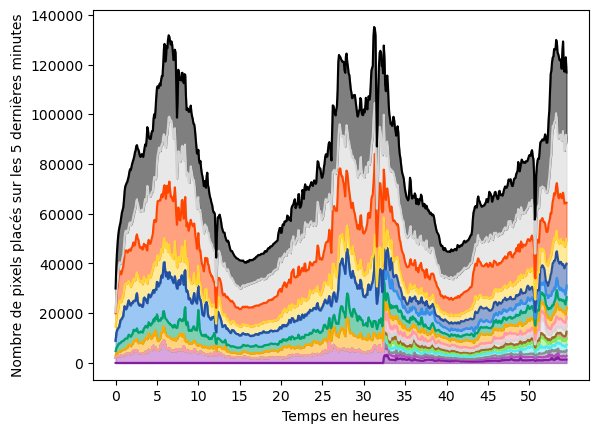

In [183]:
class all_in_one:
    def __init__(self, val) -> None:
        self.val = val
    
    def __getitem__(self, index):
        return self.val
    
    def __setitem__(self, index, val):
        self.val = val

def get_color (colors, row, is_mod):
    if not is_mod:
        colors[row.pixel_color] = colors.get(row.pixel_color, 0) + 1
    return colors

rez = []

interval = 5

visualise_at_interval(
    get_color, 
    {}, 
    pd.Timedelta(minutes = interval), 
    all_in_one(all_in_one({})),
    "",
    startingTimeStamp= pd.Timedelta(minutes = 4),
    duration = pd.Timedelta(minutes = interval),
    rez = rez,
)
colors_each_min = [image[0][0] for image in rez]
colors_each_min = colors_each_min[1:]
#sum up pixels
for i in range(0,len(colors_each_min)):
    colors_each_min[i]['total'] = 0
    for color in colors_each_min[i]:
        if color != 'total':
            colors_each_min[i]['total'] += colors_each_min[i].get(color,0)

print([image['total'] for image in colors_each_min])

#normalize numbers of pixels
'''
for i in range(0,len(colors_each_min)):
    for color in colors_each_min[i]:
        if color != 'total':
            colors_each_min[i][color] = colors_each_min[i][color] / colors_each_min[i]['total']
'''

#smooth points if necesary
smoothed_colors_each_min = []
smooth_factor = 2
for i in range(0,len(colors_each_min)-smooth_factor):
    smoothed_colors_each_min.append({})
    for color in colors_each_min[i]:
        smoothed_colors_each_min[i][color] = np.sum(
            [colors_each_min[i+j][color] for j in range(0,smooth_factor)]) / smooth_factor

#plot curve of pixels placement frequency with colors as area under the curve
import matplotlib.pyplot as plt

colors = set()
for i in range(0,len(smoothed_colors_each_min)):
    for color in colors_each_min[i]:
        if color != 'total':
            colors.add(color)

#sort colors by frequency
colors = sorted(colors, key=lambda color: smoothed_colors_each_min[-1][color])

plt.figure()
curr_y = [0 for i in range(0,len(smoothed_colors_each_min))]

for color in colors:
    if color == 'total':
        continue
    x = range(0,len(smoothed_colors_each_min))
    loc_y = [smoothed_colors_each_min[i].get(color,0) for i in range(0,len(smoothed_colors_each_min))]
    last_y = copy.deepcopy(curr_y)
    curr_y = [curr_y[i] + loc_y[i] for i in range(0,len(smoothed_colors_each_min))]
    p_color = color
    if color == '#FFFFFF': #white
        p_color = 'lightgrey'
    plt.plot(x, curr_y, color=p_color, label=color)
    plt.fill_between(x, last_y, curr_y, alpha=0.5, color=p_color)

#plot tick every x hours instead of minutes
hours_tick = 5
ticks = [i for i in range(0,len(smoothed_colors_each_min),hours_tick*60//interval)]
plt.xticks(ticks, [str(int(i*interval/60)) for i in ticks])

plt.xlabel('Temps en heures')
plt.ylabel('Nombre de pixels placés sur les 5 dernières minutes')
plt.savefig('pixel_placement_frequency_by_color.png', dpi=1000)
plt.show()


# Users activity distribution

loaded file : 2023_place_canvas_history-000000000017.csv.gzip

start making visualizations


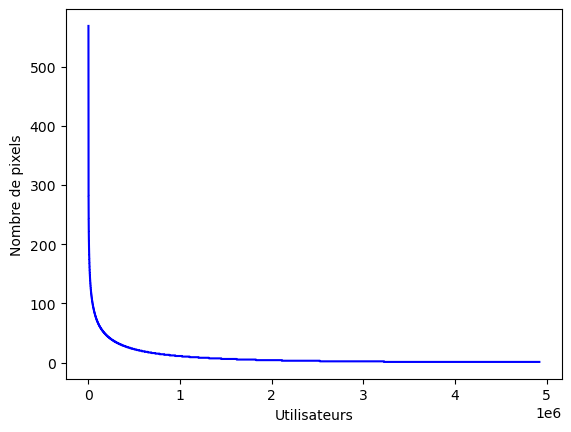

In [150]:
#aggregate how much points has been placed by each user
users_pixels = {}

def up_user_pixels(aggr, row, is_mod):
    if not is_mod:
        users_pixels[row.user] = users_pixels.get(row.user, 0) + 1 
    return users_pixels

interval = 3000
max_pixels = (interval / 5) + 1

visualise_at_interval(
    up_user_pixels, 
    {}, 
    -1, 
    all_in_one(all_in_one({})),
    "",
    EndingTimeStamp= pd.Timedelta(minutes = interval),
)

#sort users by number of pixels placed
users_pixels = sorted(users_pixels.items(), key=lambda item: item[1], reverse=True)
#remove cheaters
users_pixels = [user for user in users_pixels if user[1] < max_pixels]

#plot curve of pixels placement frequency by users
import matplotlib.pyplot as plt

plt.figure()
x = range(0,len(users_pixels))
y = [user[1] for user in users_pixels]
plt.plot(x, y, color='blue')
plt.xlabel('Utilisateurs')
plt.ylabel('Nombre de pixels')
plt.savefig('pixel_placement_frequency_by_user.png', dpi=1000)

In [6]:
stats = {'pixels': 0, 'mods': 0, 'non_mods': 0}
users = set()
def aggregate(stats, users, user, is_mod):
    users.add(user)
    stats['pixels'] += 1
    if is_mod:
        stats['mods'] += 1
    else:
        stats['non_mods'] += 1

visualise_at_interval(
    lambda x, y, user, is_mod : aggregate(stats, users, user, is_mod),
    {}, 
    pd.Timedelta(minutes= 30), 
    [["#FFFFFF" for i in range(2000)] for i in range(1000)],
    "image",
    duration= pd.Timedelta(minutes= 1)
) 
stats, users

loaded file : 2023_place_canvas_history-000000000000.csv.gzip


  0%|          | 0/4 [00:00<?, ?it/s]

265 801
-199,-235


TypeError: <lambda>() missing 1 required positional argument: 'is_mod'


matActivité forme : [x][y] = freq de maj --> image de l'activité bleu à rouge

### map:
- map de zone d'activité
- map de zone d'activité par couleur?
- map de certains utilisateurs actif 
- map de la couleur la plus utilisé
- map de la variété d'utilisateurs
- 

### statistique descriptive:
- activité par utilisateur
- activité par couleur
- activité par heure

### identifications:
- identifié les bots
- identifié communauté / projet de communauté
- identification de la modération

### technique:
- download fait
- augmentation taille grille fait
- detection des antagonistes pour trouver les communautés fait
- prétraitemtent des temps et diverse valeur pour réduire le temps d'ouverture fait